In [1]:
!pip install pyswarms

     |████████████████████████████████| 102kB 5.5MB/s 


In [2]:
import pyswarms as ps

import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

import time

from scipy.integrate import odeint,simps

In [3]:
Cva=0.0824 #kmol/m3
Cbv=1.5324 #kmol/m3
Ccv=0 #kmol/m3
q=0.0720 #m3/min
qc=0.6307  #m3/min
ro=974.19 #kg/m3
roc=998 #kg/m3
Cp=3.7187 #kJ/(kg*K)
Cpc=4.182#kJ/(kg*K)
V=2.407 #m3
Vc=2 #m3
A=8.695 #m2
alpha=13.8 #kJ/(min*m2*K)
Tv=299.05 #K
Tvc=288.15 #K
g=10183 #K
DrH=-5.46e6 #kJ/kmol
kinf=2.8233e11 #min-1

#Inicialmente....
Ca=Cva
T=Tv
Tc=Tvc
#Leitura dos dados
data=pd.read_csv('Dados_gerados_case_geral_t_2_v2', sep='\t', encoding='utf-8',header=None)

data.columns=['Tvc_','T_','Tvc_t-1','T_t-1','Tvc_t-2','T_t-2']

#data=data.drop(['qc_','Tv_','Tvc_','q_'],axis=1)

data=data.dropna()

data=data.loc[1000:,:]
#---------------------------------------------------------------------------------------


#Definição de targets

#target_tc=data.pop('Tc_')
#target_ca=data.pop('Ca_')
target=data.pop('T_')
_=data.pop('Tvc_')
#Padronização dos dados
scaler=StandardScaler()

entrada=scaler.fit_transform(data)

2020-12-20 02:46:57,362 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


In [4]:
model = tf.keras.models.load_model('Treino_LSTM_v3.h5')

In [32]:



def J(u):   
    """
    u=Tvc[t-1,t,t+1]
    model = rede neural treinada
    h_pred = horizonte de predição
    h_contr = horizonte de controle
    SP = Set-point
    """
    global model,h_pred,SP,Tvc_t_1,T_t_1,Tvc_t_2,T_t_2,T_t_1_,T_,Tvc_t_2_,T_t_2_,T_t_1_
    #Parâmetro referente ao controlador (verificar artigos)
    wT=1000
    lambda_q=10

#    start_time = time.time()
#    Loop para cálculo do horizonte de predição
    
    #Informação do Tvc para ser utilizado no df 'd_Tvc'
    Tvc_t_2_=Tvc_t_2
    
    T_t_2_=T_t_2
    T_t_1_=T_t_1
    
    T_=[]
    
    for i in range(h_pred):
        
        if i<3:
          
            T_.append(float(model(np.asarray([np.ndarray.tolist(scaler.transform([[u[i],
                                                                                   T_t_1_,Tvc_t_2_,T_t_2_]]))]),training=False)))
            Tvc_t_2_=u[i]
            
            T_t_2_=T_t_1_
            T_t_1_=T_[i]
            
        else:
            T_.append(float(model(np.asarray([np.ndarray.tolist(scaler.transform([[u[3],
                                                                               T_t_1_,Tvc_t_2_,T_t_2_]]))]),training=False)))
            Tvc_t_2_=u[3]
            
            T_t_2_=T_t_1_
            T_t_1_=T_[i]
            
#    print("--- %s seconds ---" % (time.time() - start_time))
   
    #Array com os set points no decorrer da predição
    y_ref=[SP]*h_pred
    
    #Horizonte de controle (3)
    d_Tvc=[]
    d_Tvc.append((u[0]-Tvc_t_2_)**2)
    d_Tvc.append((u[1]-u[0])**2)
    d_Tvc.append((u[2]-u[1])**2)
    d_Tvc.append((u[3]-u[2])**2)
    
       
    #função objetivo
    obj=wT*sum((pd.Series(y_ref)-pd.Series(T_))**2)+lambda_q*sum(pd.Series(d_Tvc))
    
    return obj

#EDO do sistema (cstr)
def plant(z,t):
    global q,Cva,V,kinf,g,Tv,alpha,A,ro,Cp,DrH,qc,Tvc,Vc,roc,Cpc
    Ca  = z[0]
    T   = z[1]
    Tc  = z[2]
    
    dCadt=(q*(Cva-Ca)/V)-(kinf*np.exp(-g/T)*Ca)
    dTdt=((Tv-T)*q/V) -(alpha*A*(T-Tc)/(V*ro*Cp))+(kinf*np.exp(-g/T)*Ca*(-DrH)/(ro*Cp))
    dTcdt=(qc*(Tvc-Tc)/Vc)+(alpha*A*(T-Tc)/(Vc*roc*Cpc))
    dzdt = [dCadt,dTdt,dTcdt]
    
    return dzdt


In [33]:

#FO
qc_t_1=0.6307
Tv_t_1=299.05
Tvc_t_1=288.15
q_t_1=0.072
T_t_1=296.7227
qc_t_2=0.6307
Tv_t_2=299.05
Tvc_t_2=288.15
q_t_2=0.072
T_t_2=296.7227

#Condições iniciais da EDO (partindo do estado estacionário)
Ca=0.0814416
T=296.7227
Tc=288.5237
Tvc=288.15

Tv=299.05 #K
#---------------------
#Entradas - Horizonte de predição e Set-point
h_pred=8
SP=298

z_=[]
z0 = [Ca,T,Tc]
Tvc_=[]
sp_=[]

u=[288.15,288.15,288.15,288.15]
					
def min_f(particles):
        return [J(particle) for particle in particles]
    
    
constraints = (np.array([275,275,275,275]),
               np.array([310,310,310,310]))

In [34]:
start_time = time.time()
final_step=90
for i in range(final_step):
     
    if i==25:
        Tv_t_1=300.05
        Tv_t_2=300.05
        Tv=300.05
    elif i==50:
        Tv_t_1=298.05
        Tv_t_2=298.05
        Tv=298.05
    
    options={'c1':2,'c2':2,'w':0.5}
    optimizer=ps.single.GlobalBestPSO(n_particles=15,dimensions=4,options=options,bounds=constraints)
    popt=optimizer.optimize(min_f,iters=15)
    
    
    Tvc=popt[1][0]
    Tvc_.append(Tvc)
    #Intervalos de tempo para a integração
    t = np.linspace(0,1,2)
    
    z_.append(np.ndarray.tolist(odeint(plant,z0,t)[1]))
    
    z0=z_[-1]
    
#    Atualização do valor para a próxima iteração
    Tvc_t_2=Tvc_t_1
    Tvc_t_1=Tvc

    
    T_t_2=T_t_1
    T_t_1=z0[1]
    
    u=popt[1]
    
    print(z_)
    print('\n')
    print(T_)
    
    print('\n %.1f %%'%(i*100/final_step))
    print(70*'=')
    
    sp_.append(SP)
    
print("--- %s seconds ---" % (time.time() - start_time))

2020-12-20 03:36:49,062 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|15/15, best_cost=3.67e+3
2020-12-20 03:36:56,211 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3671.437507665063, best pos: [304.73174707 304.52191452 303.56471711 301.94014813]
2020-12-20 03:36:56,224 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865]]


[296.70556640625, 296.7242126464844, 296.7317810058594, 296.7265930175781, 296.7174377441406, 296.7055969238281, 296.6919250488281, 296.6771240234375]

 0.0 %


pyswarms.single.global_best: 100%|██████████|15/15, best_cost=3.42e+3
2020-12-20 03:37:03,332 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3418.7487993100967, best pos: [307.66556665 306.26003967 303.79545934 302.48003632]
2020-12-20 03:37:03,342 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199]]


[296.8499755859375, 296.8983459472656, 297.012939453125, 297.2083740234375, 297.45538330078125, 297.7302551269531, 298.01727294921875, 298.3076477050781]

 1.1 %


pyswarms.single.global_best: 100%|██████████|15/15, best_cost=2.55e+3
2020-12-20 03:37:10,378 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2547.93975617042, best pos: [303.69431934 301.28207874 300.20740388 300.78518225]
2020-12-20 03:37:10,388 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859]]


[296.9984130859375, 297.219482421875, 297.390625, 297.49163818359375, 297.5399475097656, 297.55120849609375, 297.536376953125, 297.503173828125]

 2.2 %


pyswarms.single.global_best: 100%|██████████|15/15, best_cost=1.82e+3
2020-12-20 03:37:17,532 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1822.5713225922564, best pos: [299.56134791 299.45358491 299.02645238 298.30287843]
2020-12-20 03:37:17,543 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626]]


[297.124267578125, 297.2928771972656, 297.4659118652344, 297.635986328125, 297.8015441894531, 297.9631042480469, 298.1213684082031, 298.2771301269531]

 3.3 %


pyswarms.single.global_best: 100%|██████████|15/15, best_cost=1.35e+3
2020-12-20 03:37:24,824 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1347.5401749542434, best pos: [299.16537438 299.46205395 298.88504668 297.90539441]
2020-12-20 03:37:24,834 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882]]


[297.27294921875, 297.371826171875, 297.3746643066406, 297.3928527832031, 297.4483947753906, 297.5299072265625, 297.62908935546875, 297.7400817871094]

 4.4 %


pyswarms.single.global_best: 100%|██████████|15/15, best_cost=998
2020-12-20 03:37:31,973 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 997.8008102315363, best pos: [296.74803559 296.02451609 296.02334745 295.46323947]
2020-12-20 03:37:31,983 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226]]


[297.3597106933594, 297.4922180175781, 297.6541748046875, 297.80474853515625, 297.9355773925781, 298.0524597167969, 298.1595153808594, 298.2596435546875]

 5.6 %


pyswarms.single.global_best: 100%|██████████|15/15, best_cost=772
2020-12-20 03:37:39,043 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 772.3257861646289, best pos: [297.94254822 298.27296234 297.52162178 295.68296282]
2020-12-20 03:37:39,056 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242]]


[297.4536437988281, 297.565185546875, 297.6831970214844, 297.7933654785156, 297.89361572265625, 297.98675537109375, 298.0748291015625, 298.1593017578125]

 6.7 %


pyswarms.single.global_best: 100%|██████████|15/15, best_cost=451
2020-12-20 03:37:46,219 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 451.04313607396546, best pos: [295.00017867 294.85254249 294.50093069 294.39717147]
2020-12-20 03:37:46,236 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718]]


[297.5513000488281, 297.6285705566406, 297.7006530761719, 297.76824951171875, 297.8304443359375, 297.8887023925781, 297.944091796875, 297.9974060058594]

 7.8 %


pyswarms.single.global_best: 100%|██████████|15/15, best_cost=299
2020-12-20 03:37:53,261 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 298.75499717324885, best pos: [294.62041294 294.27925467 293.87067458 294.10223074]
2020-12-20 03:37:53,275 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277]]


[297.6410827636719, 297.73480224609375, 297.8251953125, 297.9129943847656, 297.9992370605469, 298.0843200683594, 298.1685485839844, 298.2521667480469]

 8.9 %


pyswarms.single.global_best: 100%|██████████|15/15, best_cost=242
2020-12-20 03:38:00,387 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 241.87576620174096, best pos: [292.57954279 294.17477262 293.62273752 291.95158845]
2020-12-20 03:38:00,397 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925]]


[297.6839294433594, 297.7267761230469, 297.7571716308594, 297.7795715332031, 297.79779052734375, 297.81298828125, 297.8260192871094, 297.8374328613281]

 10.0 %


pyswarms.single.global_best: 100%|██████████|15/15, best_cost=242
2020-12-20 03:38:07,445 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 241.98275846423599, best pos: [291.86590312 291.24698344 289.92907361 292.24446348]
2020-12-20 03:38:07,458 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997]]


[297.7677001953125, 297.8251647949219, 297.8686218261719, 297.90765380859375, 297.94525146484375, 297.9817810058594, 298.0174560546875, 298.052490234375]

 11.1 %


pyswarms.single.global_best: 100%|██████████|15/15, best_cost=101
2020-12-20 03:38:14,509 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 100.95488928930594, best pos: [293.18077128 293.04643035 292.45081981 292.61342199]
2020-12-20 03:38:14,523 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164]]


[297.8132629394531, 297.88140869140625, 297.960693359375, 298.03045654296875, 298.08642578125, 298.1325988769531, 298.1717834472656, 298.2059326171875]

 12.2 %


pyswarms.single.global_best: 100%|██████████|15/15, best_cost=387
2020-12-20 03:38:21,790 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 387.17250150506027, best pos: [290.8052687  287.58176084 290.24225065 291.37755857]
2020-12-20 03:38:21,803 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044]]


[297.823486328125, 297.8824157714844, 297.90618896484375, 297.9123229980469, 297.9156188964844, 297.91693115234375, 297.91680908203125, 297.9156494140625]

 13.3 %


pyswarms.single.global_best: 100%|██████████|15/15, best_cost=62.1
2020-12-20 03:38:29,142 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62.06925056429731, best pos: [291.78040742 291.68430739 291.18009806 291.49361076]
2020-12-20 03:38:29,152 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267]]


[297.854736328125, 297.8899841308594, 297.9198303222656, 297.9436950683594, 297.9631042480469, 297.97930908203125, 297.99319458

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=82.4
2020-12-20 03:38:36,379 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 82.38870930367304, best pos: [291.59277473 291.4426493  290.65729001 291.826982  ]
2020-12-20 03:38:36,390 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707]]


[297.8761901855469, 297.9228515625, 297.9739990234375, 297.9674987

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=98.9
2020-12-20 03:38:43,450 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 98.85586042435108, best pos: [292.63704214 291.56031111 291.0651393  293.02085289]
2020-12-20 03:38:43,462 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379]]


[297.8

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=93.6
2020-12-20 03:38:50,555 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 93.56041636507187, best pos: [291.22687015 290.5257864  292.19643998 291.0946683 ]
2020-12-20 03:38:50,564 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=103
2020-12-20 03:38:57,699 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 103.30635209345952, best pos: [290.94290292 291.66512417 289.81813672 291.06160518]
2020-12-20 03:38:57,709 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=93.2
2020-12-20 03:39:04,922 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 93.17472492527025, best pos: [293.03467457 294.06485124 292.36638526 291.75353242]
2020-12-20 03:39:04,934 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=266
2020-12-20 03:39:12,063 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 265.61371569628847, best pos: [288.07807686 289.127458   290.1947997  290.43549776]
2020-12-20 03:39:12,074 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=101
2020-12-20 03:39:19,391 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 100.5489681267868, best pos: [291.4554342  293.75078464 292.66587319 291.71103736]
2020-12-20 03:39:19,404 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=56.4
2020-12-20 03:39:26,510 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 56.351502557938716, best pos: [291.5592776  292.30432226 292.35562623 292.40829612]
2020-12-20 03:39:26,522 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=41
2020-12-20 03:39:33,577 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 40.953072770414735, best pos: [292.3395038  292.04556798 291.92350501 292.50897563]
2020-12-20 03:39:33,590 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=46.4
2020-12-20 03:39:40,744 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46.42428498205649, best pos: [292.37136991 292.59382352 293.02523193 292.67764305]
2020-12-20 03:39:40,755 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=56.4
2020-12-20 03:39:47,781 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 56.432147632220875, best pos: [293.30268555 292.6490619  292.24965673 291.82355516]
2020-12-20 03:39:47,789 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=67.6
2020-12-20 03:39:54,912 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 67.60874677351333, best pos: [291.86800575 292.00205055 290.45036601 290.70226711]
2020-12-20 03:39:54,925 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=22.8
2020-12-20 03:40:01,966 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 22.812103080718945, best pos: [289.32083841 289.5620905  290.11650734 290.20131532]
2020-12-20 03:40:01,980 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=9.96
2020-12-20 03:40:09,386 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9.964706532247291, best pos: [289.72203199 289.90526832 290.41391191 290.51477725]
2020-12-20 03:40:09,397 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=6.42
2020-12-20 03:40:16,491 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.423891377583278, best pos: [290.17896073 290.23555277 290.86020408 290.4874528 ]
2020-12-20 03:40:16,501 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=11.9
2020-12-20 03:40:23,630 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 11.937464533122688, best pos: [291.05908753 290.46804531 290.67296979 290.7035553 ]
2020-12-20 03:40:23,642 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=60.8
2020-12-20 03:40:30,691 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60.78160991905696, best pos: [291.09828644 291.2685617  291.24171799 289.63673188]
2020-12-20 03:40:30,701 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=11.1
2020-12-20 03:40:37,783 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 11.095917603076893, best pos: [289.59054996 289.23690204 289.37155194 289.67137937]
2020-12-20 03:40:37,796 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=22.4
2020-12-20 03:40:44,928 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 22.37846739777265, best pos: [289.50632179 289.56557423 289.57270505 288.98582617]
2020-12-20 03:40:44,943 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=31.2
2020-12-20 03:40:52,012 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 31.153913711945165, best pos: [289.97783064 289.44904751 290.39641937 290.72461198]
2020-12-20 03:40:52,022 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=26.2
2020-12-20 03:40:59,144 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 26.189097827242804, best pos: [290.03115932 290.02189197 289.11169621 289.47458768]
2020-12-20 03:40:59,155 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=55.3
2020-12-20 03:41:06,161 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 55.25899780881603, best pos: [290.77958338 290.99077169 291.00551947 290.85730302]
2020-12-20 03:41:06,176 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=121
2020-12-20 03:41:13,274 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 120.54478071216697, best pos: [291.46899275 291.52922172 290.34304472 291.3434997 ]
2020-12-20 03:41:13,287 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=22.4
2020-12-20 03:41:20,586 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 22.39072761762252, best pos: [289.01158519 289.13258802 289.3152144  289.30029948]
2020-12-20 03:41:20,596 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=86.8
2020-12-20 03:41:27,686 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 86.78453277640335, best pos: [289.90486131 291.11791704 290.74783757 290.24931007]
2020-12-20 03:41:27,700 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=40.8
2020-12-20 03:41:34,784 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 40.81534117975475, best pos: [289.29289366 289.8768791  289.57681328 290.22263936]
2020-12-20 03:41:34,794 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=50.7
2020-12-20 03:41:41,785 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 50.7312549969443, best pos: [289.21459896 290.34822975 290.50336533 289.74844026]
2020-12-20 03:41:41,797 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=63.4
2020-12-20 03:41:48,942 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63.36442089526051, best pos: [290.3255412  289.54869326 288.96100523 288.80189104]
2020-12-20 03:41:48,952 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=27.6
2020-12-20 03:41:56,044 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27.590946200198708, best pos: [289.0166892  289.54053352 289.58655302 289.79173827]
2020-12-20 03:41:56,057 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=35
2020-12-20 03:42:03,029 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35.01487365507875, best pos: [289.66460853 288.83767408 289.03782026 289.24158744]
2020-12-20 03:42:03,038 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=40.6
2020-12-20 03:42:10,321 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 40.57861372231319, best pos: [288.8085454  288.52194243 288.85838245 289.03077659]
2020-12-20 03:42:10,331 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=70.3
2020-12-20 03:42:17,414 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 70.27311659058127, best pos: [290.9131213  289.82913853 290.09560651 289.2829278 ]
2020-12-20 03:42:17,423 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=39.8
2020-12-20 03:42:24,490 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39.82596900525064, best pos: [290.02404425 290.57539064 290.68497177 290.6573036 ]
2020-12-20 03:42:24,501 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=129
2020-12-20 03:42:31,624 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 129.3208322322715, best pos: [289.68776024 289.43457278 291.61180942 289.25881944]
2020-12-20 03:42:31,636 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=23.4
2020-12-20 03:42:38,725 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 23.369389550597734, best pos: [289.41801111 289.58224615 289.9279439  289.43847699]
2020-12-20 03:42:38,735 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=38.2
2020-12-20 03:42:45,847 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 38.235088021173304, best pos: [290.15598832 290.62761965 289.68783215 289.84262558]
2020-12-20 03:42:45,864 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=49.5
2020-12-20 03:42:53,033 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 49.53180346729368, best pos: [289.16339149 288.54874495 289.5535889  290.41073127]
2020-12-20 03:42:53,046 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=21.6
2020-12-20 03:42:59,981 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 21.608936072641704, best pos: [291.81945605 291.14280327 291.67116717 291.38431173]
2020-12-20 03:42:59,991 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=100
2020-12-20 03:43:07,060 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 100.43724611982375, best pos: [290.64652023 290.76867391 291.36857229 291.43405746]
2020-12-20 03:43:07,070 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=58.2
2020-12-20 03:43:14,342 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 58.19288705149029, best pos: [293.20158579 293.40739434 294.07378806 293.06530016]
2020-12-20 03:43:14,351 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=77.8
2020-12-20 03:43:21,458 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 77.83337050562862, best pos: [292.87311628 293.29162347 292.60895929 292.25444234]
2020-12-20 03:43:21,470 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=97
2020-12-20 03:43:28,609 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 97.0164647140881, best pos: [293.20174953 293.44739917 294.25965323 292.89884946]
2020-12-20 03:43:28,623 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=131
2020-12-20 03:43:35,668 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 131.37716368946565, best pos: [294.97216433 294.96228179 294.47569733 294.14480463]
2020-12-20 03:43:35,679 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=111
2020-12-20 03:43:43,010 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 110.91417378021377, best pos: [294.63767134 294.03100424 293.64462682 293.59239113]
2020-12-20 03:43:43,021 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=87.3
2020-12-20 03:43:50,254 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 87.33518482897541, best pos: [293.61647541 293.21322464 292.86058033 292.98736435]
2020-12-20 03:43:50,266 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=95.1
2020-12-20 03:43:57,589 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 95.0522368566947, best pos: [292.61663432 292.92947538 292.18426513 292.28631377]
2020-12-20 03:43:57,604 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=95.6
2020-12-20 03:44:04,740 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 95.58825241283877, best pos: [293.72419717 293.96654749 293.30202071 293.08064793]
2020-12-20 03:44:04,759 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=110
2020-12-20 03:44:11,858 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109.69073090211964, best pos: [292.92694667 292.44222929 292.35802736 292.98006615]
2020-12-20 03:44:11,867 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=104
2020-12-20 03:44:19,247 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 103.53747924738364, best pos: [293.01378969 293.26466187 293.21151163 293.48060798]
2020-12-20 03:44:19,258 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=169
2020-12-20 03:44:26,367 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 168.91115973537703, best pos: [293.49212369 295.14298081 293.02691473 292.7605641 ]
2020-12-20 03:44:26,379 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=115
2020-12-20 03:44:33,488 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 115.06390839337128, best pos: [293.35435516 293.32215536 293.02350075 292.42136582]
2020-12-20 03:44:33,504 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=179
2020-12-20 03:44:40,667 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 179.13634572916317, best pos: [294.09358915 294.39727228 293.82429619 294.97620203]
2020-12-20 03:44:40,678 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=124
2020-12-20 03:44:47,699 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 124.06850532876683, best pos: [293.36754852 292.4644422  292.75365788 292.64107351]
2020-12-20 03:44:47,712 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=170
2020-12-20 03:44:54,769 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 170.31571228956793, best pos: [294.91476746 294.54462418 292.53345821 293.31284819]
2020-12-20 03:44:54,786 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=102
2020-12-20 03:45:01,885 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 102.33777677101496, best pos: [293.65455185 293.83955624 293.53580996 293.04536503]
2020-12-20 03:45:01,897 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=154
2020-12-20 03:45:08,937 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 154.17325596199748, best pos: [294.55648693 293.84636355 294.27035744 294.49043057]
2020-12-20 03:45:08,952 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=198
2020-12-20 03:45:16,045 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 197.9139358847551, best pos: [293.33644921 294.95536337 292.30631435 293.34602207]
2020-12-20 03:45:16,058 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=111
2020-12-20 03:45:23,139 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 110.50794669080724, best pos: [292.99921503 292.64108738 292.00532946 293.36871054]
2020-12-20 03:45:23,158 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=179
2020-12-20 03:45:30,295 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 178.95287621469612, best pos: [291.03060363 291.6556195  291.80125974 292.93134037]
2020-12-20 03:45:30,305 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=174
2020-12-20 03:45:37,348 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 173.93072255923772, best pos: [292.93666842 294.17200103 294.84758698 292.31638313]
2020-12-20 03:45:37,357 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=112
2020-12-20 03:45:44,310 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 112.41479425626339, best pos: [293.3881021  293.4747757  293.46941974 293.32741373]
2020-12-20 03:45:44,323 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=311
2020-12-20 03:45:51,273 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 311.26178830167333, best pos: [292.62122286 292.98005931 290.06279664 291.34976659]
2020-12-20 03:45:51,289 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=127
2020-12-20 03:45:58,437 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 126.67173286645857, best pos: [293.21494888 293.79958676 293.46401938 292.85403336]
2020-12-20 03:45:58,451 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=176
2020-12-20 03:46:05,482 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 175.83001204181633, best pos: [293.69034387 292.44213985 293.51364629 292.77110973]
2020-12-20 03:46:05,493 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=150
2020-12-20 03:46:12,591 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 149.91379330245604, best pos: [292.87727723 293.87917429 293.25884906 293.21889433]
2020-12-20 03:46:12,603 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=141
2020-12-20 03:46:19,891 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 141.14887823909862, best pos: [294.37026212 294.56390261 294.19287634 293.41745339]
2020-12-20 03:46:19,908 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=194
2020-12-20 03:46:26,960 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 194.4832074810305, best pos: [294.69721036 292.60212913 293.09518605 293.2093702 ]
2020-12-20 03:46:26,972 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=181
2020-12-20 03:46:33,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 181.48494060976668, best pos: [293.88605587 294.86210615 294.69406354 294.67242616]
2020-12-20 03:46:33,994 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=119
2020-12-20 03:46:41,008 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 118.99904389700771, best pos: [293.50464499 293.0596747  292.59076805 292.90818604]
2020-12-20 03:46:41,020 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=135
2020-12-20 03:46:48,030 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 134.6721669799624, best pos: [294.64741202 294.25201644 293.71817559 293.16169943]
2020-12-20 03:46:48,043 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=114
2020-12-20 03:46:55,040 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 113.6809186911488, best pos: [293.99527817 293.91838718 293.14345471 293.37616528]
2020-12-20 03:46:55,051 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=132
2020-12-20 03:47:02,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 132.25144264046529, best pos: [293.10746961 291.65193301 292.48931473 292.93809205]
2020-12-20 03:47:02,064 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=96
2020-12-20 03:47:09,450 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 96.01876280062079, best pos: [293.4401618  293.49535707 293.14491733 293.28606865]
2020-12-20 03:47:09,461 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=101
2020-12-20 03:47:16,489 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 100.83764425532141, best pos: [293.52543741 293.86157444 293.69235066 293.33741508]
2020-12-20 03:47:16,498 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=182
2020-12-20 03:47:23,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 181.70756487859745, best pos: [292.1958809  293.36439519 294.7299395  292.36936493]
2020-12-20 03:47:23,616 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/15

[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=110
2020-12-20 03:47:30,773 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 110.05260810587022, best pos: [293.46973353 293.38200303 294.04895064 293.20150551]


[[0.08144156527320877, 296.75460418492133, 292.9782591609865], [0.08144133282334422, 296.84211440619094, 296.9705082294199], [0.08144075073017822, 296.9645351060911, 298.7759405610859], [0.08143975536715863, 297.0951241536601, 298.96558811181626], [0.08143835101679761, 297.2222120727865, 298.9971771129882], [0.08143656366214387, 297.34023345584114, 298.37202895583226], [0.08143443598631232, 297.44894244202294, 298.2447325615242], [0.08143200472985615, 297.5464532128447, 297.3640432134718], [0.08142932471654717, 297.62946593395907, 296.62980059520277], [0.08142645247393007, 297.6970122383694, 295.55446642985925], [0.08142345119576871, 297.74830734849667, 294.59018321025997], [0.08142037427893656, 297.7891388585505, 294.25051526629164], [0.08141725585094814, 297.81997243723686, 293.36855631221044], [0.08141413680090526, 297.84139847817045, 292.99658504355267], [0.0814110422731983, 297.8573897463119, 292.67891410405707], [0.08140798684826162, 297.8711438190773, 292.731164859379], [0.08140

In [35]:
import matplotlib.pyplot as plt


In [36]:
"""
Plotagem dos resultados
"""
p_=pd.DataFrame(z_)

SAVE_RESULTS=p_.copy()
SAVE_RESULTS['sp']=sp_
SAVE_RESULTS['Tvc']=Tvc_


#SAVE_RESULTS.to_csv('Result_LSTM_V8.csv', sep='\t', encoding='utf-8', header=None, index=False)


In [37]:
#Métricas de erro
IAE=simps(abs(sp_-p_[1]))
ISE=simps((sp_-p_[1])**2)
ITAE=simps(np.linspace(0,final_step-1,final_step)*abs(sp_-p_[1]))
ITSE=simps(np.linspace(0,final_step-1,final_step)*((sp_-p_[1])**2))


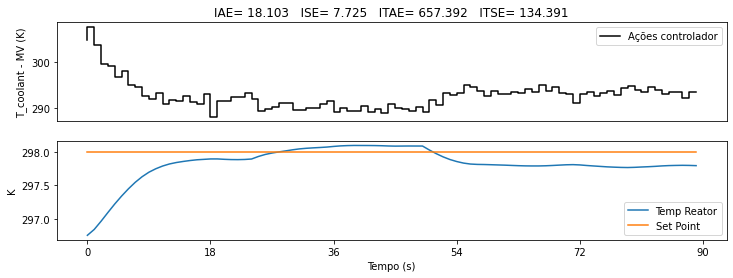

In [38]:



#Plotagem
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.title("IAE= "+'%.3f'%IAE+ "   ISE= "+'%.3f'%ISE+"   ITAE= "+'%.3f'%ITAE+"   ITSE= "+'%.3f'%ITSE)
plt.step(np.linspace(0,final_step-1,final_step),Tvc_,'k',label='Ações controlador')
plt.ylabel('T_coolant - MV (K)')
#plt.xlabel('Tempo (s)')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.legend()


#plt.figure(figsize=(12,4))
plt.subplot(2,1,2)
plt.plot(p_[1],label='Temp Reator')
plt.plot(sp_,label='Set Point')
plt.ylabel('K')
plt.xlabel('Tempo (s)')

plt.xticks(np.linspace(0,final_step,6))
plt.legend()

plt.show()

